In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

In [102]:
import math
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

import seaborn as sns
import time
import json
import pandas as pd
from ctypes import c_int32
from itertools import product

from scipy.stats import pearsonr
from importlib import reload

from lib import sketches
from lib import visualization_utils
reload(sketches)

from lib.sketches import BloomFilter, CountMinSketch, minimal_b_adic_cover, sort_b_adic_ranges, BAdicRange, BAdicCube, minimal_spatial_b_adic_cover, H3HashFunctions, HashFunctionFamily
from lib.visualization_utils import visualize_badic_cover, plot_b_adic_cubes

In [95]:
import timeit
import hashlib


def _hashes(item, hash_count, limit):
    """
    Generate hash values for the item.
    """
    for i in range(hash_count):
        hash_value = int(hashlib.md5((str(item) + str(i)).encode()).hexdigest(), 16)
        yield hash_value % limit

# Create instances of the classes
h3_hash_functions = H3HashFunctions(n_functions=3, limit=50000)
hash_function_family = HashFunctionFamily(num_hashes=3, max_range=50000)

# Define a sample input for the hash_values method
sample_input = (12345, 67890, 54321)

# Measure the execution time of H3HashFunctions.hash_values
h3_time = timeit.timeit(lambda: h3_hash_functions.hash_value(892927), number=1000)

# Measure the execution time of HashFunctionFamily.hash_values
hash_family_time = timeit.timeit(lambda: hash_function_family.hash_value(892927), number=1000)

hashes_time = timeit.timeit(lambda: _hashes(892927, 3, 50000), number=1000)

print(f"H3HashFunctions.hash_values execution time: {h3_time} seconds")
print(f"HashFunctionFamily.hash_values execution time: {hash_family_time} seconds")
print(f"Custom hash function execution time: {hashes_time} seconds")

H3HashFunctions.hash_values execution time: 0.026682371011702344 seconds
HashFunctionFamily.hash_values execution time: 0.00040630699368193746 seconds
Custom hash function execution time: 5.5980999604798853e-05 seconds


# Data Generation

In [14]:
def generate_normal_dataset(size, num_columns, mean, std_dev, output_path=None):
    """
    Generates a dataset with the specified parameters where each column
    contains integer values following a normal distribution.

    Parameters:
    - size (int): Number of rows in the dataset.
    - num_columns (int): Number of columns in the dataset.
    - mean (float): Mean of the normal distribution.
    - std_dev (float): Standard deviation of the normal distribution.
    - output_dir (str, optional): Directory to save the dataset in Parquet format. Defaults to None.

    Returns:
    - pd.DataFrame: Generated dataset as a pandas DataFrame.
    """
    # Generate random data for each column
    data = {
        f"d_{i}": np.random.normal(loc=mean, scale=std_dev, size=size).astype(int)
        for i in range(num_columns)
    }

    # Create DataFrame
    df = pd.DataFrame(data)

    # Save to output directory if specified
    if output_path:
        df.to_parquet(output_path, index=False)
        print(f"Dataset saved to {output_path}")

    return df


In [15]:
df = generate_normal_dataset(size=100000, num_columns=3, mean=5000, std_dev=50, output_path="data/normal_3d_100k.parquet")

Dataset saved to data/normal_3d_100k.parquet


In [16]:
df = pd.read_parquet("data/normal_3d_100k.parquet")

In [1]:
df.describe()

NameError: name 'df' is not defined

In [19]:
np.log2(500)

np.float64(8.965784284662087)

# Build Count-Min Sketches

In [20]:
base = 2
levels = 9
dimensions = 3

In [5]:
def encode(tuple_value):
    return c_int32(hash(tuple_value)).value

In [41]:
def build_sketches(df, base, levels, dimensions):
    cm_sketches = []
    for i in range(levels):
        cm_sketches.append(CountMinSketch(300000, 5))

    for index, row in df.iterrows():
        # Encode the tuple as a 32-bit integer
        row = tuple(row)
        for l in range(levels):
            cube = []
            for d in range(dimensions):
                cube.append(row[d] // base**l)
            cube = tuple(cube)
            # encoded_value = encode(cube)
            cm_sketches[l].update(cube)

    return cm_sketches

In [24]:
cm_sketches_2 = build_sketches(df, base=2, levels=9, dimensions=3)

In [43]:
cm_sketches_5 = build_sketches(df, base=5, levels=4, dimensions=3)

In [25]:
np.log(500)/np.log(5)

np.float64(3.8613531161467862)

# Evaluation

## Base = 5  :  Levels = 4

In [110]:
levels = 4

# Create queries
lower_bound = 4800
upper_bound = 5200 - base ** (levels-1)
n_samples = 20

queries = []

for l in range(levels):
    l_queries = []
    for i in range(n_samples):
        start = np.random.randint(lower_bound, upper_bound)
        end = start + base**l - 1
        query = [(int(start), int(end))] * dimensions
        l_queries.append(query)
    queries.append(l_queries)

In [ ]:
base = 5
dimensions = 3
cm_sketches = cm_sketches_5

true_results = []
estimates = []
n_cubes = []
absolute_errors = []
relative_errors = []
n_level_0_cubes = []

# level_errors = [0]*levels
# level_queries = [0]*levels

for l in range(levels):
    l_true_results = []
    l_estimates = []
    l_n_cubes = []
    l_absolute_errors = []
    l_relative_errors = []
    l_n_level_0_cubes = []

    for i in range(n_samples):
        query = queries[l][i]

        true_result = df.query(" and ".join([f"d_{i} >= {query[i][0]} and d_{i} <= {query[i][1]}" for i in range(dimensions)])).shape[0]
        bases = [base] * dimensions
        cubes = minimal_spatial_b_adic_cover(query, bases)
        estimate = 0
        n_level_0 = 0
        for cube in cubes:
            if cube.level == 0:
                n_level_0 += 1
            tuple_value = tuple([r.index for r in cube.b_adic_ranges])
            cube_extimate = cm_sketches[cube.level].query(tuple_value)
            estimate += cube_extimate

            # cube_result = df.query(" and ".join([f"d_{i} >= {cube.b_adic_ranges[i].low} and d_{i} < {cube.b_adic_ranges[i].high}" for i in range(len(cube.b_adic_ranges))])).shape[0]
            # level_errors[cube.level] += abs(cube_result - cube_extimate)
            # level_queries[cube.level] += 1

        l_n_level_0_cubes.append(n_level_0)
        l_true_results.append(true_result)
        l_estimates.append(int(estimate))
        l_n_cubes.append(len(cubes))
        l_absolute_errors.append(int(abs(true_result - estimate)))
        if true_result != 0:
            l_relative_errors.append(abs(true_result - estimate) / true_result)
        else:
            l_relative_errors.append(abs(true_result - estimate))
    
    print(f"level compleated: {l}")
    true_results.append(l_true_results)
    estimates.append(l_estimates)
    n_cubes.append(l_n_cubes)
    absolute_errors.append(l_absolute_errors)
    relative_errors.append(l_relative_errors)
    n_level_0_cubes.append(l_n_level_0_cubes)

level compleated: 0
level compleated: 1
level compleated: 2


KeyboardInterrupt: 

In [152]:
" and ".join([f"d_{i} >= {cube.b_adic_ranges[i].low} and d_{i} < {cube.b_adic_ranges[i].high}" for i in range(len(cube.b_adic_ranges))])

'd_0 >= 4951 and d_0 < 4952 and d_1 >= 4951 and d_1 < 4952 and d_2 >= 4951 and d_2 < 4952'

In [112]:
print(absolute_errors)
print(n_level_0_cubes)

[[0, 1, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0], [38, 35, 45, 46, 48, 48, 46, 33, 44, 28, 38, 34, 37, 27, 0, 0, 32, 41, 35, 0], [2624, 2364, 2499, 2528, 2620, 2537, 2501, 2557, 2446, 2432, 2378, 2658, 41, 2462, 2640, 14, 2472, 2553, 2541, 2561], [74827, 76240, 75528, 1668, 76365, 76125, 1575, 1820, 76804, 75304, 74976, 73882, 75356, 77565, 74587, 76136, 76397, 76419, 76040, 76618]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 0, 0, 125, 125, 125, 0], [7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 0, 7625, 7625, 0, 7625, 7625, 7625, 7625], [225125, 225125, 225125, 0, 225125, 225125, 0, 0, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125]]


In [113]:
np.array(absolute_errors)/np.array(n_level_0_cubes)

/tmp/ipykernel_888/162705037.py:1: RuntimeWarning: divide by zero encountered in divide
  np.array(absolute_errors)/np.array(n_level_0_cubes)
/tmp/ipykernel_888/162705037.py:1: RuntimeWarning: invalid value encountered in divide
  np.array(absolute_errors)/np.array(n_level_0_cubes)


array([[0.        , 1.        , 0.        , 1.        , 2.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.304     , 0.28      , 0.36      , 0.368     , 0.384     ,
        0.384     , 0.368     , 0.264     , 0.352     , 0.224     ,
        0.304     , 0.272     , 0.296     , 0.216     ,        nan,
               nan, 0.256     , 0.328     , 0.28      ,        nan],
       [0.34413115, 0.31003279, 0.3277377 , 0.33154098, 0.34360656,
        0.33272131, 0.328     , 0.33534426, 0.32078689, 0.31895082,
        0.31186885, 0.34859016,        inf, 0.32288525, 0.34622951,
               inf, 0.32419672, 0.33481967, 0.3332459 , 0.33586885],
       [0.33237979, 0.3386563 , 0.33549361,        inf, 0.33921155,
        0.33814547,        inf,        inf, 0.34116158, 0.33449861,
        0.33304164, 0.32818212, 0.33472959, 0

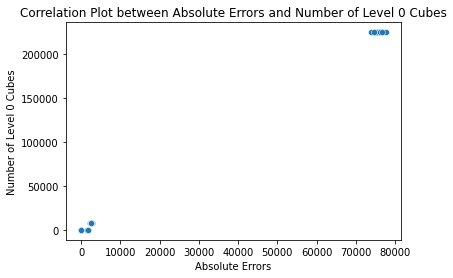

Pearson correlation coefficient: 0.9998538679320456
P-value: 1.3139251259185166e-139


In [114]:
flat_absolute_errors = np.array(absolute_errors).flatten()
flat_n_level_0_cubes = np.array(n_level_0_cubes).flatten()

# Plot the correlation plot
sns.scatterplot(x=flat_absolute_errors, y=flat_n_level_0_cubes)
plt.xlabel('Absolute Errors')
plt.ylabel('Number of Level 0 Cubes')
plt.title('Correlation Plot between Absolute Errors and Number of Level 0 Cubes')
plt.show()

# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(flat_absolute_errors, flat_n_level_0_cubes)
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

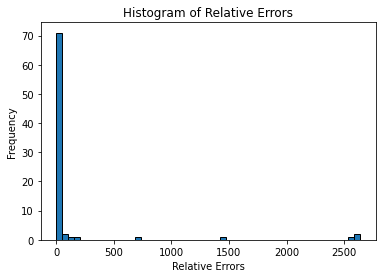

In [133]:
flat_relative_errors = np.array(relative_errors).flatten()

# Plot the histogram
plt.hist(flat_relative_errors, bins=50, edgecolor='black')
plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors')
plt.show()

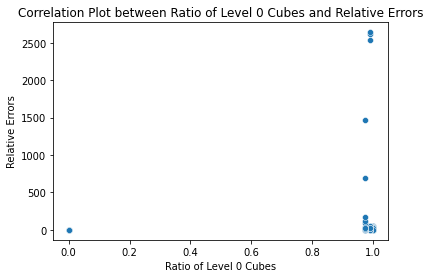

Pearson correlation coefficient: 0.9998538679320456
P-value: 1.3139251259185166e-139


In [116]:
flat_n_cubes = np.array(n_cubes).flatten()
ratio_n_level_0_cubes = flat_n_level_0_cubes / flat_n_cubes

# Plot the correlation plot
sns.scatterplot(x=ratio_n_level_0_cubes, y=flat_relative_errors)
plt.xlabel('Ratio of Level 0 Cubes')
plt.ylabel('Relative Errors')
plt.title('Correlation Plot between Ratio of Level 0 Cubes and Relative Errors')
plt.show()

correlation_coefficient, p_value = pearsonr(flat_absolute_errors, flat_n_level_0_cubes)
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

In [144]:
max_index = np.argmax(flat_relative_errors)
print(f"Query index: {max_index}")
print(f"Max relative error: {np.max(flat_relative_errors)}")
print(f"Absolute error: {flat_absolute_errors[max_index]}")
print(f"Ratio of level 0 cubes: {ratio_n_level_0_cubes[max_index]}")
print(f"Number of cubes: {flat_n_cubes[max_index]}")


Query index: 54
Max relative error: 2640.0
Absolute error: 2640
Ratio of level 0 cubes: 0.9916764208609702
Number of cubes: 7689


# Bloom Filter Optimization

In [107]:
n = len(df)  # Number of expected elements
p = 0.01  # Desired false positive probability
bloom = BloomFilter(n_values=n, p=p)

for index, row in df.iterrows():
    row = tuple(row)
    bloom.update(row)

In [119]:
base = 5
dimensions = 3
cm_sketches = cm_sketches_5

estimates_b = []
n_cubes_b = []
absolute_errors_b = []
relative_errors_b = []
n_level_0_cubes_b = []

for l in range(levels):
    l_true_results = []
    l_estimates = []
    l_n_cubes = []
    l_absolute_errors = []
    l_relative_errors = []
    l_n_level_0_cubes = []

    for i in range(n_samples):
        query = queries[l][i]

        true_result = true_results[l][i]
        bases = [base] * dimensions
        cubes = minimal_spatial_b_adic_cover(query, bases)
        estimate = 0
        n_level_0 = 0
        for cube in cubes:
            if cube.level == 0:
                n_level_0 += 1
                tuple_value = tuple([r.index for r in cube.b_adic_ranges])
                estimate += bloom.query(tuple_value)
            else:
                tuple_value = tuple([r.index for r in cube.b_adic_ranges])
                estimate += cm_sketches[cube.level].query(tuple_value)

        l_n_level_0_cubes.append(n_level_0)
        l_true_results.append(true_result)
        l_estimates.append(int(estimate))
        l_n_cubes.append(len(cubes))
        l_absolute_errors.append(int(abs(true_result - estimate)))
        if true_result != 0:
            l_relative_errors.append(abs(true_result - estimate) / true_result)
        else:
            l_relative_errors.append(abs(true_result - estimate))
    
    print(f"level compleated: {l}")
    estimates_b.append(l_estimates)
    n_cubes_b.append(l_n_cubes)
    absolute_errors_b.append(l_absolute_errors)
    relative_errors_b.append(l_relative_errors)
    n_level_0_cubes_b.append(l_n_level_0_cubes)

level compleated: 0
level compleated: 1
level compleated: 2
level compleated: 3


In [150]:
[0]*4

[0, 0, 0, 0]

In [120]:
print(absolute_errors_b)
print(n_level_0_cubes_b)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [17, 11, 14, 7, 10, 12, 12, 14, 19, 11, 14, 17, 13, 9, 0, 0, 13, 13, 11, 0], [783, 785, 805, 806, 705, 809, 725, 788, 748, 742, 782, 813, 41, 772, 712, 14, 756, 836, 698, 809], [23649, 24405, 23512, 1668, 23314, 24286, 1575, 1820, 23414, 24050, 24017, 23354, 24397, 24215, 23877, 24071, 23189, 24341, 24656, 23722]]
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 125, 0, 0, 125, 125, 125, 0], [7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 7625, 0, 7625, 7625, 0, 7625, 7625, 7625, 7625], [225125, 225125, 225125, 0, 225125, 225125, 0, 0, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125, 225125]]


In [122]:
np.array(absolute_errors_b)/np.array(n_level_0_cubes_b)

/tmp/ipykernel_888/2450666678.py:1: RuntimeWarning: divide by zero encountered in divide
  np.array(absolute_errors_b)/np.array(n_level_0_cubes_b)
/tmp/ipykernel_888/2450666678.py:1: RuntimeWarning: invalid value encountered in divide
  np.array(absolute_errors_b)/np.array(n_level_0_cubes_b)


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.136     , 0.088     , 0.112     , 0.056     , 0.08      ,
        0.096     , 0.096     , 0.112     , 0.152     , 0.088     ,
        0.112     , 0.136     , 0.104     , 0.072     ,        nan,
               nan, 0.104     , 0.104     , 0.088     ,        nan],
       [0.10268852, 0.10295082, 0.10557377, 0.10570492, 0.09245902,
        0.10609836, 0.09508197, 0.10334426, 0.09809836, 0.09731148,
        0.10255738, 0.10662295,        inf, 0.1012459 , 0.09337705,
               inf, 0.09914754, 0.10963934, 0.09154098, 0.10609836],
       [0.10504831, 0.10840644, 0.10443976,        inf, 0.10356024,
        0.10787785,        inf,        inf, 0.10400444, 0.10682954,
        0.10668295, 0.10373792, 0.10837091, 0

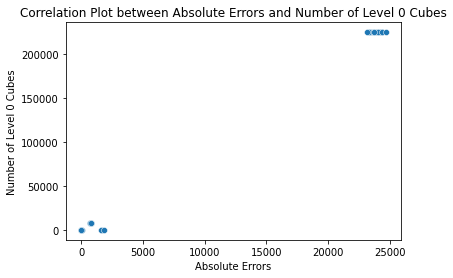

Pearson correlation coefficient: 0.9992289173883164
P-value: 1.929307277200963e-111


In [123]:
flat_absolute_errors_b = np.array(absolute_errors_b).flatten()
flat_n_level_0_cubes_b = np.array(n_level_0_cubes_b).flatten()

# Plot the correlation plot
sns.scatterplot(x=flat_absolute_errors_b, y=flat_n_level_0_cubes_b)
plt.xlabel('Absolute Errors')
plt.ylabel('Number of Level 0 Cubes')
plt.title('Correlation Plot between Absolute Errors and Number of Level 0 Cubes')
plt.show()

# Calculate the Pearson correlation coefficient
correlation_coefficient, p_value = pearsonr(flat_absolute_errors_b, flat_n_level_0_cubes_b)
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

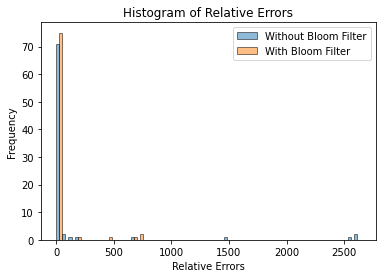

In [146]:

flat_relative_errors_b = np.array(relative_errors_b).flatten()
flat_relative_errors = np.array(relative_errors).flatten()

# flat_relative_errors_b = flat_relative_errors_b[flat_relative_errors_b < 1]
# flat_relative_errors = flat_relative_errors[flat_relative_errors < 1]

# Align the bars' boundaries of both histograms
bins = np.linspace(0, max(flat_relative_errors.max(), flat_relative_errors_b.max()), 50)

# Compute the bin centers
bin_width = bins[1] - bins[0]
bin_centers = bins[:-1] + bin_width / 2

# Calculate the histogram data
hist_a, _ = np.histogram(flat_relative_errors, bins=bins)
hist_b, _ = np.histogram(flat_relative_errors_b, bins=bins)

# Plot the histograms side by side
plt.bar(bin_centers - bin_width / 4, hist_a, width=bin_width / 2, edgecolor='black', alpha=0.5, label='Without Bloom Filter')
plt.bar(bin_centers + bin_width / 4, hist_b, width=bin_width / 2, edgecolor='black', alpha=0.5, label='With Bloom Filter')

plt.xlabel('Relative Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Errors')
plt.legend()
plt.show()


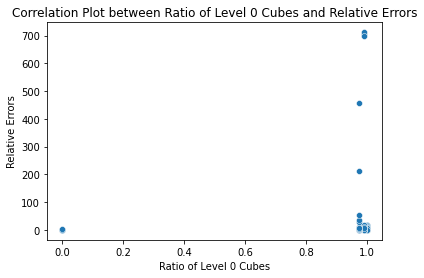

Pearson correlation coefficient: 0.9992289173883164
P-value: 1.929307277200963e-111


In [140]:
flat_n_cubes_b = np.array(n_cubes_b).flatten()
ratio_n_level_0_cubes_b = flat_n_level_0_cubes_b / flat_n_cubes_b

# Plot the correlation plot
sns.scatterplot(x=ratio_n_level_0_cubes_b, y=flat_relative_errors_b)
plt.xlabel('Ratio of Level 0 Cubes')
plt.ylabel('Relative Errors')
plt.title('Correlation Plot between Ratio of Level 0 Cubes and Relative Errors')
plt.show()

correlation_coefficient, p_value = pearsonr(flat_absolute_errors_b, flat_n_level_0_cubes_b)
print(f'Pearson correlation coefficient: {correlation_coefficient}')
print(f'P-value: {p_value}')

In [142]:
max_index = np.argmax(flat_relative_errors_b)
print(f"Query index: {max_index}")
print(f"Max relative error: {np.max(flat_relative_errors_b)}")
print(f"Absolute error: {flat_absolute_errors_b[max_index]}")
print(f"Ratio of level 0 cubes: {ratio_n_level_0_cubes_b[max_index]}")
print(f"Number of cubes: {flat_n_cubes_b[max_index]}")


Query index: 54
Max relative error: 712.0
Absolute error: 712
Ratio of level 0 cubes: 0.9916764208609702
Number of cubes: 7689


In [54]:
for l in range(cm_sketches[0].depth):
    count = 0 
    for i in range(cm_sketches[0].width):
        if cm_sketches[0].counters[l][i] != 0:
            count += 1
    print(count) 

84653
84653
84653
84653
84651


In [55]:
cm_sketches[0].width

300000

In [50]:
print(cm_sketches[0].to_string())

Count-Min Sketch
depth = 5 width = 300000 ; processed elements = 100000
[[2 0 0 ... 1 0 1]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 0 0 2]
 [1 0 0 ... 0 1 0]
 [1 2 0 ... 0 0 0]]
